# Homework - NSGA-II


- Vadym Repetskyi 155610
- Adam Korba


In [237]:
import matplotlib.pyplot as plt
import numpy as np

In [238]:
### Solution class
class Solution:
    def __init__(self, x, f, name):
        self.x = x  ### decision variables
        self.f = f  ### evaluation vector [f1, f2]
        self.front = 0  ## additional variable storing id of non-dominated front
        self.cd = 0.0  ## additional variable storing value of crowding distance
        self.name = name  ### additional variable storing name of the solution

    def __str__(self):
        return "[" + self.name + " : F = " + str(self.f) + "]"

In [239]:
### TODO you need to fill a method for evaluation of solution basing on decision variable


def evaluate(x):
    x1, x2, x3, x4, x5 = x

    l = 1 + abs(pow(x2, 10) - 0.5) + x3 + x4 + x5
    x1_10 = pow(x1, 10)

    f1 = x1_10 * l
    f2 = (1 - x1_10) * l

    return [f1, f2]

In [240]:
### Method for initial population construction for the given size N


def constructInitialPopulation(N):
    P = []
    for i in range(N):
        x = [j for j in range(5)]
        x[0] = np.random.rand()
        x[1] = np.random.rand()
        for j in range(2, 5):
            x[j] = np.random.randint(0, 2)
        f = evaluate(x)
        P.append(Solution(x, f, str(0) + "-" + str(i)))  ### adding solution to list
        # which name consists of two parts: generation number
        # in which the solution was created and the number of solution in the population
    return P


P = constructInitialPopulation(10000)
for s in P[:10]:
    print(s)  ### Print exemplary solutions (just for tests)

[0-0 : F = [2.0157167264203578e-07, 3.499254879318905]]
[0-1 : F = [0.11468113630052032, 4.3836888138400365]]
[0-2 : F = [0.0011888627209579148, 2.4984569939877685]]
[0-3 : F = [0.0033161972847225688, 3.496683731442012]]
[0-4 : F = [0.00043016074578999493, 2.4995698392488315]]
[0-5 : F = [1.2418232664203147e-05, 2.057798651638861]]
[0-6 : F = [0.05938712027670312, 2.3759609384576965]]
[0-7 : F = [0.5699071718782297, 3.930090374632239]]
[0-8 : F = [0.002203415971378169, 4.497791384512181]]
[0-9 : F = [1.3485112808017284e-07, 1.4999934051090378]]


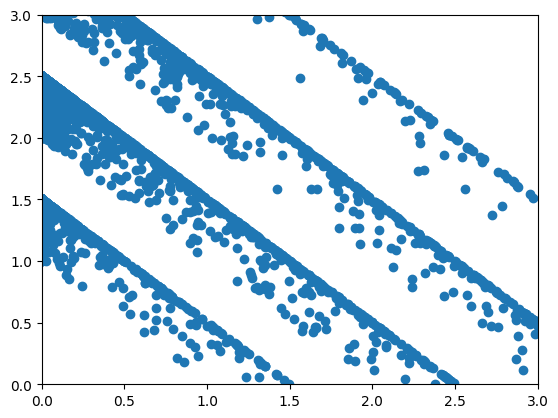

In [241]:
### Below function draws solutions in P
### In big size of N we can see how randomly generated solutions appear
### Please check it e.g. for N=10000.
### TODO Justify the distribution referring to the definition of the problem.


def plotPopul(P):
    plt.figure()
    X = [s.f[0] for s in P]
    Y = [s.f[1] for s in P]
    plt.plot(X, Y, ls="", marker="o")
    plt.xlim(0, 3.0)
    plt.ylim(0, 3.0)


plotPopul(P)

The shape of the distribution is justified by the fact that the objective functions are related. They share the term _l_, which is scaled by _x1 \*\* 10_ and _(1 - x1 \*\* 10)_ respectively. This results in solutions grouped in diagonal lines.


In [242]:
### TODO below function should return list of pairs of solution indices chosen for reproduction.
### From each pair there will be created one descendant individual.
### Selection should be made on the basis on tournament (size 2)
### Output: list of pairs -> [ [idx11, idx12],...,[idxN1, idxN2] ]


def constructParents(N):
    return np.random.randint(0, len(P), size=N * 2).reshape((N, 2))


print(constructParents(10))  ### TEST

[[8099 9475]
 [9363 2268]
 [9656 6369]
 [1533 4807]
 [9815 8538]
 [4502 8251]
 [ 633 6627]
 [ 481 3293]
 [2414  610]
 [4287 1968]]


In [243]:
# TODO below function should make a crossover of two input vectors
# There can be any type of crossover implemented.


def getCrossed(xA, xB):
    # one-point crossover
    p = np.random.randint(1, len(xA))
    return [xA[i] if i < p else xB[i] for i in range(len(xA))]


print(getCrossed([0.0, 0.5, 1.0], [1.0, 0.25, 0.75]))  ### TEST

[0.0, 0.5, 0.75]


In [244]:
# TODO the below function should mutate the input vector x.
# You need to take into account the probability of mutation for each decision variable.
# In case of binary variables, the mutation should be made as a complement to 1:
# new x[i] = 1 - x[i]
# In case of continuous variables, you can use gaussian mutation
# You need to have a protection from potential exceeding values out of  [0, 1] interval.


def mutate(x, prob, std):
    for i in range(5):
        if np.random.random() > prob:
            continue

        if i > 1:
            x[i] = 1 - x[i]
        else:
            x[i] += np.random.normal(0, std)
            x[i] = np.clip(x[i], 0, 1)

    return x


for std in [0.0, 0.1, 0.2]:  ## TEST
    x = [0.0, 0.2, 1.0, 0.0, 0.0]
    mutate(x, 1.0, std)
    print(x)

[0.0, 0.2, 0.0, 1.0, 1.0]
[0.0, 0.2318164090629977, 0.0, 1.0, 1.0]
[0.16113271464085155, 0.0, 0.0, 1.0, 1.0]


In [245]:
### Please read the below method
### It generates the vector of descendant solutions basing on selected parents
### and chosen reproduction operators.


def constructOffspring(P, parents, gen, std):
    O = []
    prob = 1.0 / 5.0
    for i in range(len(parents)):
        xO = getCrossed(P[parents[i][0]].x, P[parents[i][1]].x)
        mutate(xO, prob, std)
        O.append(Solution(xO, evaluate(xO), str(gen) + "-" + str(i)))
    return O

In [246]:
# Method for checking the existence of dominance relation
def dominates(sj, sk):
    if sj.f[0] < sk.f[0] and sj.f[1] <= sk.f[1]:
        return True
    if sj.f[0] <= sk.f[0] and sj.f[1] < sk.f[1]:
        return True
    return False

In [247]:
### TODO Below method should do the assignemnt of solutions to non-dominated fronts
### The output should be list of list of indices of solutions in P, assigned to proper fronts.
### E.g. the output  [[3,4,0],[1,5],[2]] means that the solutions with ids 0, 3 and 4 are in a first front,
### 1 and 5 in second front and 2 in the last one.


def getNonDominatedFronts(P: list[Solution]):
    remaining = set(P)

    def getFront(remaining: set):
        dominated = set()

        for s1 in remaining:
            for s2 in remaining:
                if s1 == s2:
                    continue

                if dominates(s2, s1):
                    dominated.update((s1,))
                    break

        non_dominated = set(remaining) - dominated

        return non_dominated

    F = []
    while remaining:
        front = getFront(remaining)
        F.append([P.index(s) for s in front])
        remaining = remaining - front

    return F

In [248]:
### TODO below method should calculate values of crowding distance (CD) for solutions in P.
### ATTENTION: CD is calculated for each non-dominated front separately;
### Method should return the vector of calculated CD

INF = 1000


def getCrowdingDistances(F, P):
    CD = [0] * len(P)

    for front in F:
        for m in range(len(P[0].f)):
            front.sort(key=lambda i: P[i].f[m])

            CD[front[0]] = INF
            CD[front[-1]] = INF

            obj_min = P[front[0]].f[m]
            obj_max = P[front[-1]].f[m]

            if obj_max == obj_min:
                continue

            for j in range(1, len(front) - 1):
                next_obj_val = P[front[j + 1]].f[m]
                prev_obj_val = P[front[j - 1]].f[m]
                distance = (next_obj_val - prev_obj_val) / (obj_max - obj_min)
                CD[front[j]] += distance

    return CD

In [249]:
### Below method assigns to solutions their numbers of non-dominated fronts and crowding
# distances values then sort solutions in the population basing on these metrics.
# In case useCD = False, crowding distances is not taken into account while sorting.
# Testing the method for useCD = True and False let us see the gain
# coming from the usage of crowding distances.


def applyScoresAndSort(P, useCD=True):
    F = getNonDominatedFronts(P)
    CD = [0 for _ in P]
    if useCD:
        CD = getCrowdingDistances(F, P)
        mi, ma = min(CD), max(CD)  ### crowding distances normalization
        if abs(mi - ma) < 0.00001:
            CD = [0.5 for _ in range(len(P))]
        CD = [(v - mi) / (ma - mi) for v in CD]

    for s, f in enumerate(F):
        for i in f:
            P[i].front = s
            P[i].cd = CD[i]

    P.sort(key=lambda x: x.front - x.cd * 0.5)  # Kryterium sortowania

In [250]:
# TODO Below method should calculate additional statistics which may help
# justify the usage of crowding distances in calculations.
# The method should return average, max and min crowding distances value
# for the solutions and std dev in population P.
# While calculations, omit the boundary values (inf).
# How can we interpret these measures?


def getStatsCD(P):
    CD = [s.cd for s in P if not s.cd == INF]
    return np.mean(CD), np.max(CD), np.min(CD), np.std(CD)

- Average gives a sense of the overall spread in the population
- Max indicates the solution with the most diversity
- Min indicates the solution with the least diversity
- Standard Deviation gives us the idea of how uniform the spread is


These two cells below show how NSGA-II algoritm works, illustrate created solutions in 5 different stages of algorithm and finally write stats for CD. In the first cell CD is not used while sorting and in the second it is used. You need to read the code and test it for different values of parameters (e.g. population size).
For which variant the algorithm works best?

**Additional task:** evolutionary algorithms are random. That is why running them one time may not be credible. To get more credible result, the algorithm may be run e.g. 20 times and the statistics averaged. Additionally, you can calculate them for each generation and plot their convergence. Moreover, you can plot this for both varinats of algorithm (with and without CD).

However, the stats for CD may not be the best way for scoring the algorithm. You can see that the solutions are highly scattered at the beginning and their CD values are high which is not compatible with the assumption that the higher value, of CD, the better. For better algorithm evaluation, you can use metrics which estimate the distance to Pareto front. You can propose such a method and use it to show the closeness of population to this front. Then when you get this metic and metrics for scoring the dispersion of solutions, you can better compare algorithms.


(0.0, 0, 0, 0.0)


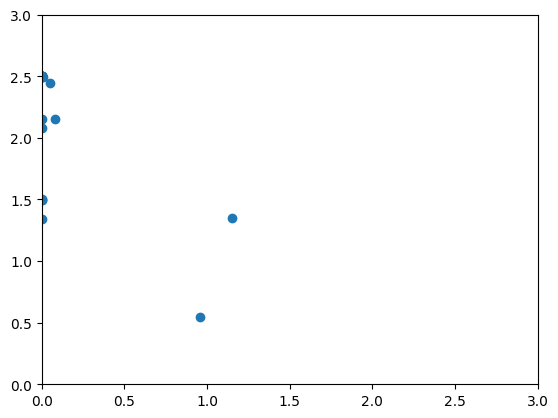

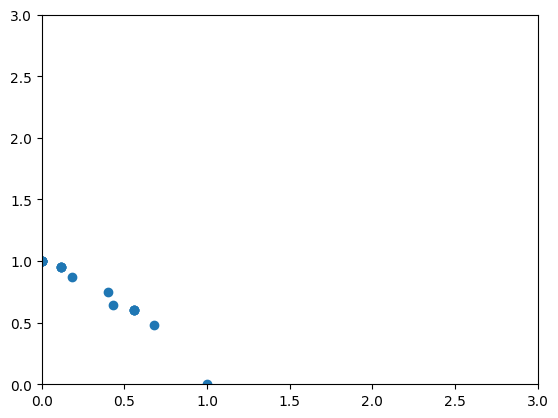

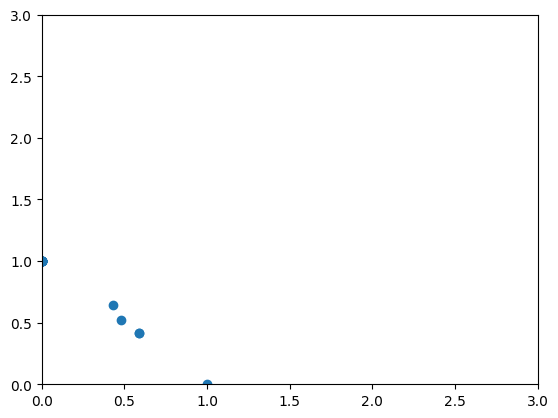

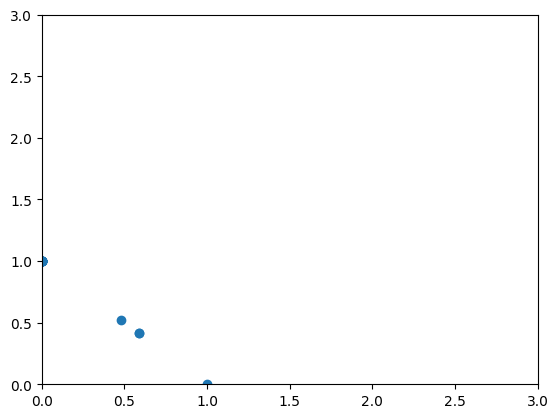

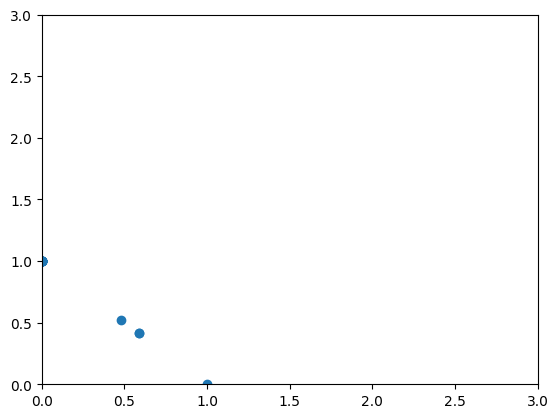

In [251]:
### Omitting CD
N = 20  # population size
GEN = 100  # generation number/ number of iterations

P = constructInitialPopulation(N)
applyScoresAndSort(P, useCD=False)

for gen in range(GEN):
    C = constructParents(N)
    O = constructOffspring(P, C, gen + 1, 0.1)
    M = P + O
    applyScoresAndSort(M, useCD=False)
    P = M[:N]  # get N best individuals
    if gen % (GEN / 4) == 0 or gen == GEN - 1:
        plotPopul(P)  # step size for population illustration

# print stats
print(getStatsCD(P))

(0.2001575111406198, 1.0, 0.00013668892780441526, 0.3998810276228597)


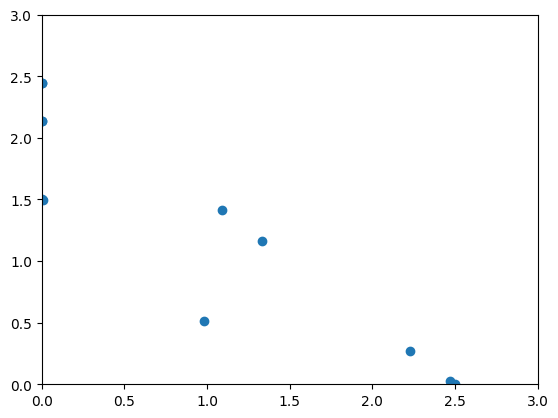

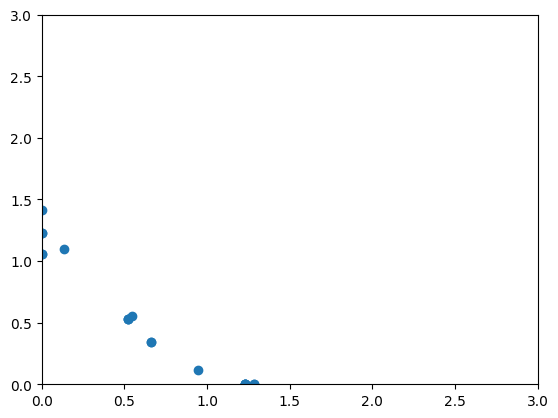

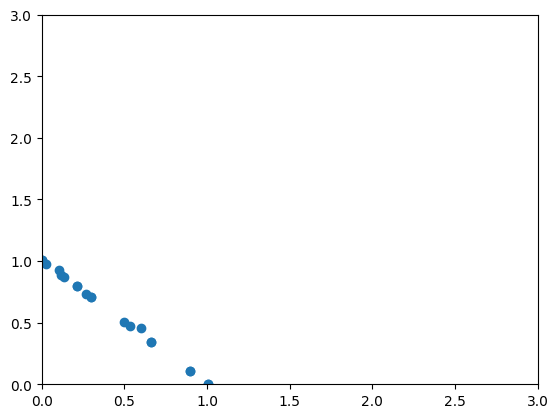

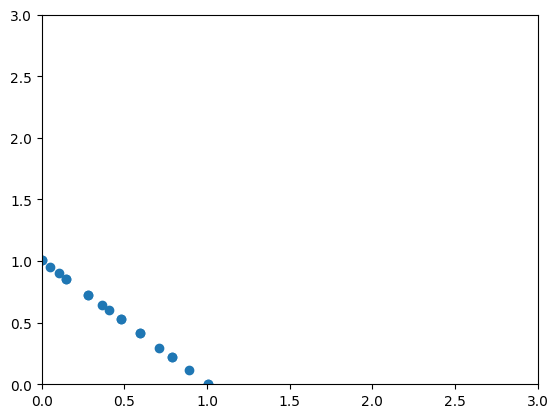

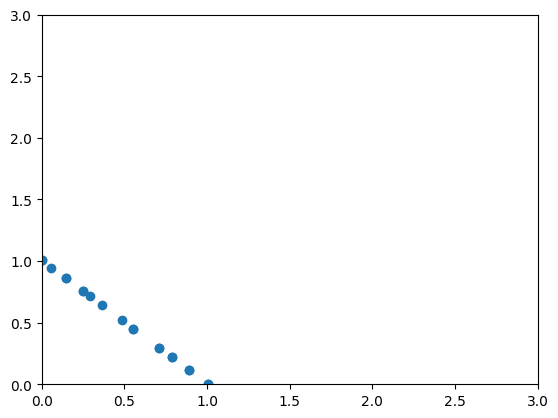

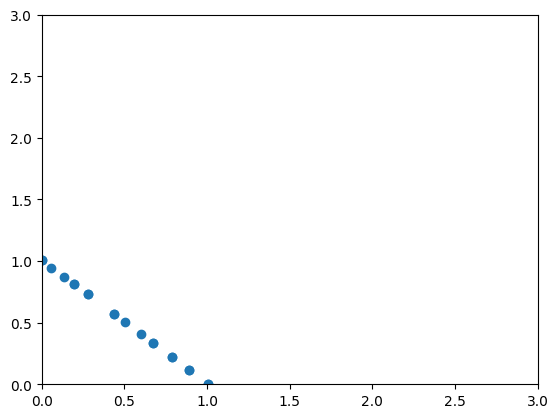

In [252]:
### With CD
N = 20
GEN = 100

P = constructInitialPopulation(N)
applyScoresAndSort(P, useCD=True)

for gen in range(GEN):
    C = constructParents(N)
    O = constructOffspring(P, C, gen + 1, 0.1)
    M = P + O
    applyScoresAndSort(M, useCD=True)
    P = M[:N]
    if gen % (GEN / 5) == 0 or gen == GEN - 1:
        plotPopul(P)

print(getStatsCD(P))